In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as ss

In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor,kernels
from sklearn.model_selection import train_test_split, KFold,LeaveOneOut
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error,mean_squared_error

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from src.models.constants import Constants
from src.models import util
from src.models.gaussian_process import featurize

In [6]:
plt.style.use('seaborn-v0_8-talk')
cmap = plt.get_cmap("tab10")
raw_dir = "C:/Users/Hermans_Desktop1/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/raw"
processed_dir = "C:/Users/Hermans_Desktop1/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/processed"
n_map = {1:"Base",2:"Thru Rnd 1",3:"Thru Rnd 2",4:"Thru Rnd 3",5:"Thru Rnd 4",6:"Thru Rnd 5",7:"Thru Rnd 6-GP"}
seed=0
fname = f'3-averaged_Round7-Standardized.csv' #Data through Round 6 w. GP
f = processed_dir+"/"+fname
df = pd.read_csv(f,index_col=0)
X,y=util.get_Xy(df)
print(f'Num Samples: {X.shape[0]}, Num Features: {X.shape[1]}')
print(f'Range of y: {max(y)-min(y):.3} Mean of y: {y.mean():.3} SD of y: {y.std():.3}')
X.head()



Num Samples: 68, Num Features: 7
Range of y: 4.29 Mean of y: 3.37 SD of y: 1.18


,Sn,Ga,Fe,Cu,Ca,diversity,loading
0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,0.0,0.0,0.0,0.0,1.0,1,1.0
2,0.0,0.0,0.0,0.0,4.0,1,4.0
3,0.0,0.0,0.0,0.0,8.0,1,8.0
4,0.0,0.0,0.0,1.0,0.0,1,1.0


In [8]:
X,y=util.get_Xy(df)
n = X.shape[0]
X = X.to_numpy()
y = y.to_numpy()
y_preds = []
y_stds = []
y_actuals = []
loo = KFold(n_splits=n)
for train_index,test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pipeline = make_pipeline(GaussianProcessRegressor(kernel=1*kernels.RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2)),n_restarts_optimizer=5,random_state=seed))
    pipeline.fit(X_train,y_train)
    y_pred,y_pred_std = pipeline.predict(X_test,return_std=True)
    y_preds.append(y_pred[0])
    y_stds.append(y_pred_std[0])
    y_actuals.append(y_test[0])



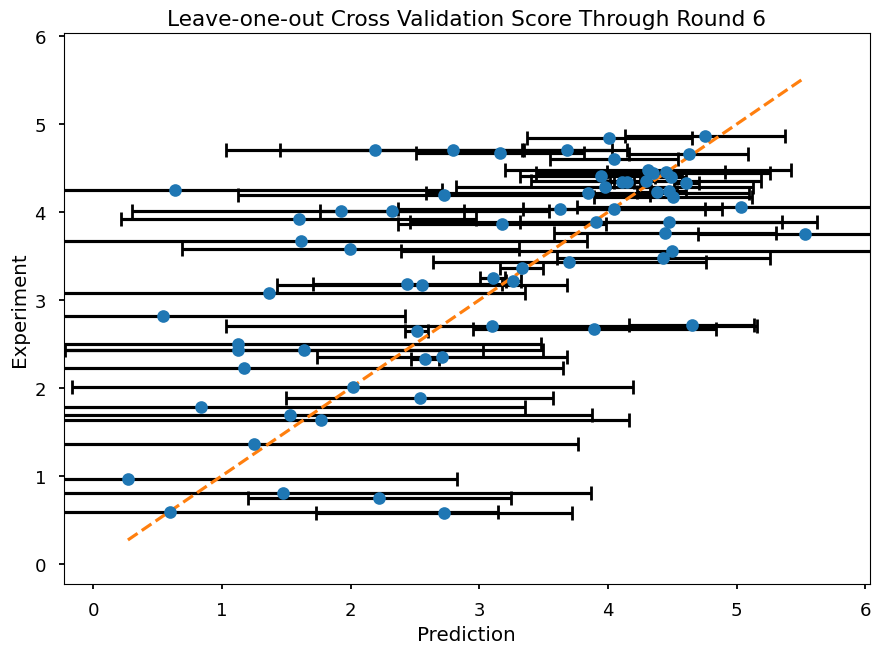

In [9]:
plt.errorbar(y_preds, y_actuals, xerr=y_stds, capsize=5, capthick=2, fmt="o", ecolor = "black")
# plt.plot(y_preds,y_actuals,'o')
plt.plot([min(y_preds),max(y_preds)],[min(y_preds),max(y_preds)],'--')
plt.xlabel("Prediction")
plt.ylabel("Experiment")
plt.xlim((min(y_preds)-.5,max(y_preds)+.5))
plt.ylim((min(y_preds)-.5,max(y_preds)+.5))
plt.title("Leave-one-out Cross Validation Score Through Round 6")
#plt.savefig("./figures/LOO-CV-Thru_Rnd_4-With_Error_Bars.png",dpi=600,bbox_inches='tight')
plt.show()

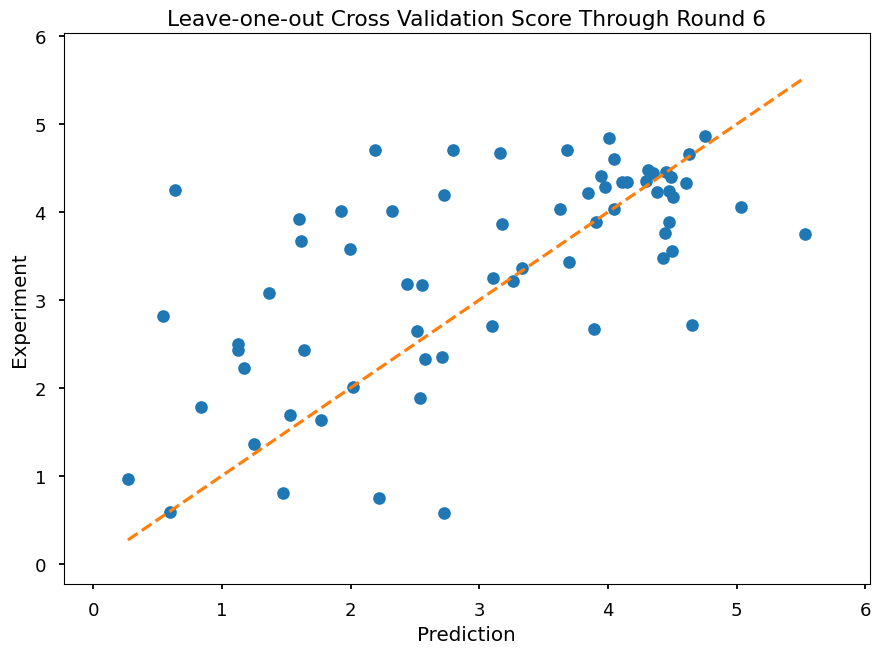

In [10]:
plt.plot(y_preds, y_actuals, 'o')
# plt.plot(y_preds,y_actuals,'o')
plt.plot([min(y_preds),max(y_preds)],[min(y_preds),max(y_preds)],'--')
plt.xlabel("Prediction")
plt.ylabel("Experiment")
plt.xlim((min(y_preds)-.5,max(y_preds)+.5))
plt.ylim((min(y_preds)-.5,max(y_preds)+.5))
plt.title("Leave-one-out Cross Validation Score Through Round 6")
#plt.savefig("./figures/LOO-CV-Thru_Rnd_4-Without_Error_Bars.png",dpi=600,bbox_inches='tight')
plt.show()

In [11]:
mean_absolute_error(y_actuals,y_preds)

0.8090853043486068

# 2) Performance on 26 base catalysts with successive rounds

In [20]:
from src.data.make_dataset import make_cat_dict,calc_reactor_metrics
from src.models.constants import Constants
from src.models.util import generate_grid,split,EI,generate_prediction_array,GP_regressor
from src.models.gaussian_process import featurize

def avg(df):
    print("Performing averaging")
    print(f'Currently {len(df)} catalyst samples in matrix.')
    metals_to_avg_on = Constants().ALL_TESTED_METALS
    df['idx'] = df.index
    columns_to_retain = Constants().METRICS
    columns_to_retain.append("idx")
    df_avg = df.groupby(Constants().ALL_TESTED_METALS)[columns_to_retain].mean().reset_index()
    df_avg=df_avg.sort_values("idx")
    df_avg.head()
    sd_pct_lifetime = .176
    sd_pct_Y_pc = .033/2
    sd_pct_sqrtY0Y_pc = .033/2 #placeholder
    df_avg["lifetime_yield_sd"] = df_avg["lifetime_yield"]*sd_pct_lifetime #producing an estimated SD for a parameter
    df_avg["Y_pc_sd"] = df_avg["Y_pc"]*sd_pct_Y_pc #producing an estimated SD for a parameter
    df_avg["sqrtY0Y_pc_sd"] = df_avg["sqrtY0Y_pc"]*sd_pct_sqrtY0Y_pc
    df_avg = df_avg.drop(columns=["idx"])
    return df_avg

In [26]:

#load in reactor data
label_list = []
res_list = []

for n in range(1,8,1):
    for metric in ["sqrtY0Ypc_0-240"]:
        fname = f'2-cleanedup_Round{n}-Standardized.csv'
        f = processed_dir+"/"+fname
        df = pd.read_csv(f,index_col=0)
        df = avg(df) #average with index
        df_features,df_targets = featurize(df)
        X = df_features.to_numpy()
        if metric == "sqrtY0Ypc_0-240":
            Y_pc = -df_targets['Y0']/df_targets['k_d'] * (np.exp(-df_targets['k_d']*240)-np.exp(-df_targets['k_d']*0))
            chosen_metric = np.sqrt(df_targets['Y0']*Y_pc).to_numpy()
        elif metric == "sqrtY0Ypc_10-240":
            Y_pc = -df_targets['Y0']/df_targets['k_d'] * (np.exp(-df_targets['k_d']*240)-np.exp(-df_targets['k_d']*10))
            chosen_metric = np.sqrt(df_targets['Y0']*Y_pc).to_numpy()
        elif metric == "0-inf":
            Y_pc = df_targets['Y0']/df_targets['k_d']
            chosen_metric = np.sqrt(df_targets['Y0']*Y_pc).to_numpy()  
        elif metric == "Ypc_0-240":
            chosen_metric = -df_targets['Y0']/df_targets['k_d'] * (np.exp(-df_targets['k_d']*240)-np.exp(-df_targets['k_d']*0))
        elif metric == "Ypc_10-240":
            chosen_metric = -df_targets['Y0']/df_targets['k_d'] * (np.exp(-df_targets['k_d']*240)-np.exp(-df_targets['k_d']*10))
        y = chosen_metric
        y = np.asarray([[i,0] for i in y])
        print(f'Round {n} Total data points: {len(df_features)}')
        loo = LeaveOneOut().split(X,y=y)
        results = []
        for i, (i_train,i_test) in enumerate(loo):
            mu,sigma = GP_regressor(X[i_train],y[i_train],X[i_test],verbose=False)
            results.append((i_test,y[i_test,0],mu,sigma))

        all_expt = np.asarray([tup[1] for tup in results])
        all_pred = np.asarray([tup[2] for tup in results])

        if n == 1:
            expt=all_expt[:,0]
            pred=all_pred[:,0]
        else:
            if n==6:
                expt=all_expt[0:26,0]
                pred=all_pred[0:26,0]
                new_expt=all_expt[-12:] #separate out new points
                new_pred = all_pred[-12:] #separate out new points    
            else:
                expt=all_expt[0:26,0]
                pred=all_pred[0:26,0]
                new_expt=all_expt[-6:] #separate out new points
                new_pred = all_pred[-6:] #separate out new points
        print(f'Round {n} Total tested points: {len(expt)}')
        mae = np.mean(np.abs(pred-expt))
        slope, intercept, r_value, p_value, std_err = ss.linregress(expt,pred)
        r2 = r_value**2
        rmse = np.sqrt(mean_squared_error(expt,pred))
        mae_norm = np.mean(np.abs(pred-expt)/expt)
        rmse_norm = rmse / np.mean(expt)
        label=f'Round {n} Metric {metric} GP Norm_MAE {mae_norm:.3} Norm_RMSE {rmse_norm:.3} R2: {r2:.3}'
        res = {'n':n,'metric':metric,'mae_norm':mae_norm,'rmse_norm':rmse_norm,'r2':r2}
        res_list.append(res)
        label_list.append(label)
print('\n-------------------------------------------------------------------------\n')
for label in label_list:
    print(label)

Performing averaging
Currently 40 catalyst samples in matrix.
Round 1 Total data points: 26
Round 1 Total tested points: 26
Performing averaging
Currently 46 catalyst samples in matrix.
Round 2 Total data points: 32
Round 2 Total tested points: 26
Performing averaging
Currently 52 catalyst samples in matrix.
Round 3 Total data points: 38
Round 3 Total tested points: 26
Performing averaging
Currently 58 catalyst samples in matrix.
Round 4 Total data points: 44
Round 4 Total tested points: 26
Performing averaging
Currently 64 catalyst samples in matrix.
Round 5 Total data points: 50
Round 5 Total tested points: 26
Performing averaging
Currently 76 catalyst samples in matrix.
Round 6 Total data points: 62
Round 6 Total tested points: 26
Performing averaging
Currently 82 catalyst samples in matrix.
Round 7 Total data points: 68
Round 7 Total tested points: 26

-------------------------------------------------------------------------

Round 1 Metric sqrtY0Ypc_0-240 GP Norm_MAE 0.621 Norm_RM

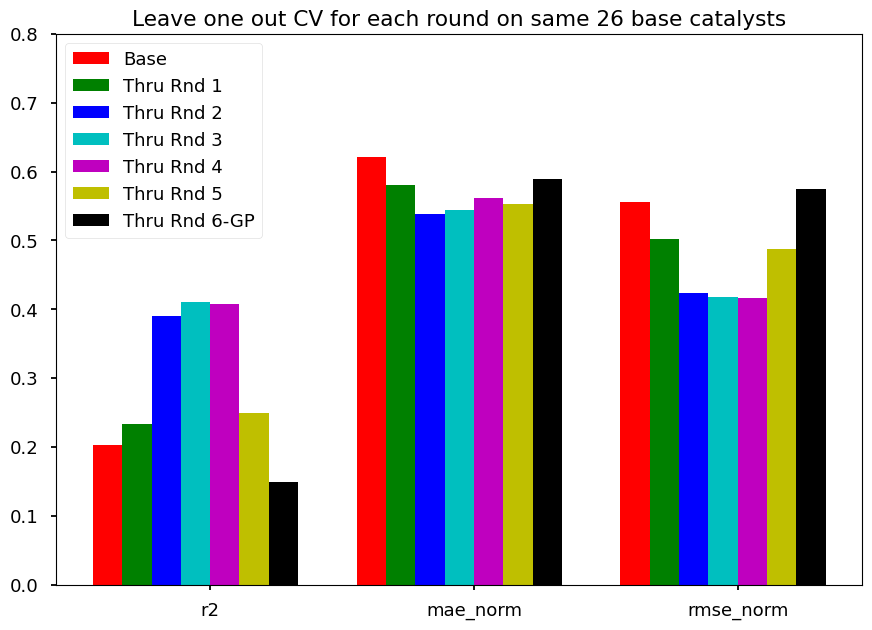

In [32]:
width = 1/9
scores = {"mae_norm":1,"rmse_norm":2,"r2":0}

color_list = ['r','g','b','c','m','y','k']
#https://matplotlib.org/stable/gallery/color/named_colors.html
fig, ax = plt.subplots()
for i,val in enumerate(['mae_norm','rmse_norm','r2']):
    
    for res in res_list:
        if val == "mae_norm":
            ax.bar(scores[val]+width*res["n"],res[val],width=width,color=color_list[res["n"]-1],label=f'{n_map[res["n"]]}')
        else:
            ax.bar(scores[val]+width*res["n"],res[val],width=width,color=color_list[res["n"]-1])
            

    plt.xticks(np.asarray(list(scores.values()))+.5,list(scores.keys()))
    plt.title("Leave one out CV for each round on same 26 base catalysts")
    plt.legend(loc='upper left')
    plt.ylim((0,.8))
plt.show()

